Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [31]:
import pathlib
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense, Flatten, Dropout

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
            "Skin cancer ISIC The International Skin Imaging Collaboration/Train",
            labels = 'inferred',
            validation_split = 0.2,
            subset="training",
            seed = 123,
            image_size = (img_height,img_width),
            batch_size = batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


2021-09-28 13:25:43.209467: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-28 13:25:43.209857: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /snap/alacritty/46/usr/lib/x86_64-linux-gnu:/snap/alacritty/46/lib/x86_64-linux-gnu:/snap/alacritty/46/usr/lib/x86_64-linux-gnu/dri
2021-09-28 13:25:43.209997: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /snap/alacritty/46/usr/lib/x86_64-linux-gnu:/snap/alacritty/46/lib/x86_64-linux-gnu:/snap/alacritty/46/usr/lib/x86_64-linux-gnu/dri
2021-09-28 13:25:43.2101

In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
            "Skin cancer ISIC The International Skin Imaging Collaboration/Train",
            labels = 'inferred',
            validation_split = 0.2,
            subset="validation",
            seed = 123,
            image_size = (img_height,img_width),
            batch_size = batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

2021-09-28 13:25:43.491944: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


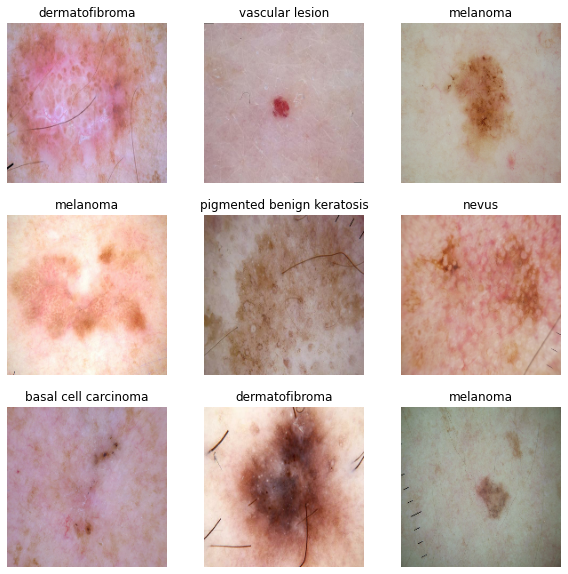

In [9]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
### Your code goes here
#number of classes.
num_classes = 9
#Sequential layers with normalized values 
model = Sequential(
        [layers.experimental.preprocessing.Rescaling(1./255, 
         input_shape=(img_height, img_width, 3))])
#first convolutional layer
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
#second convolutional layer
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
#pooling layer
model.add(MaxPooling2D(pool_size=(2,2)))
#flatten layer
model.add(Flatten())
#Fully connected layer
model.add(Dense(128,activation = 'relu'))
#Softmax layer
model.add(Dense(num_classes, activation = 'softmax' ))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [12]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 176, 176, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 88, 88, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 495616)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               63438976  
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 1

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/home/ajaxgen/anaconda3/envs/msmlai/lib/python3.9/site-packages/keras/backend.py:4906: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


169/169 [==============================] - 218s 1s/step - loss: 3.3536 - accuracy: 0.2485 - val_loss: 1.7326 - val_accuracy: 0.3497
Epoch 2/20
169/169 [==============================] - 169s 994ms/step - loss: 1.5536 - accuracy: 0.4199 - val_loss: 1.3441 - val_accuracy: 0.4863
Epoch 3/20
169/169 [==============================] - 168s 993ms/step - loss: 1.2773 - accuracy: 0.5432 - val_loss: 1.2700 - val_accuracy: 0.5449
Epoch 4/20
169/169 [==============================] - 168s 993ms/step - loss: 1.0363 - accuracy: 0.6398 - val_loss: 1.1401 - val_accuracy: 0.6147
Epoch 5/20
169/169 [==============================] - 169s 999ms/step - loss: 0.8138 - accuracy: 0.7342 - val_loss: 1.1381 - val_accuracy: 0.6392
Epoch 6/20
169/169 [==============================] - 169s 998ms/step - loss: 0.6422 - accuracy: 0.7947 - val_loss: 1.0368 - val_accuracy: 0.6630
Epoch 7/20
169/169 [==============================] - 169s 999ms/step - loss: 0.4714 - accuracy: 0.8507 - val_loss: 1.0668 - val_accuracy:

### Visualizing training results

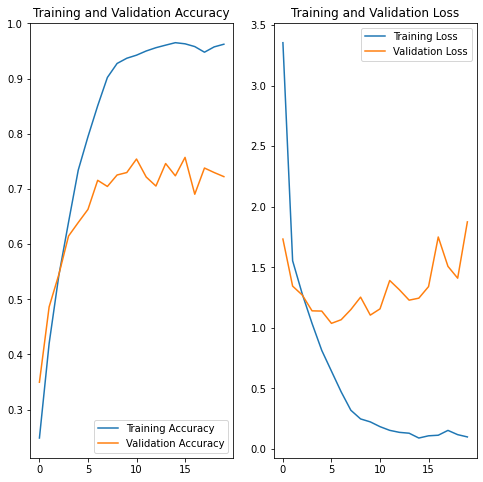

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

<font color="blue">
<ul>
    <li>There is a big difference between the training accuracy and the validation accuracy. This suggests that the model has overfitted the data.</li>
    <li>The cause for overfitting is probably the less amount of data.</li>
    <li>To fix this we could use a few methods</li>
    <ul>
        <li>Data augmentation: generating new images from existing images.</li>
        <li>Regularization: Adding dropout to control the overfit.</li>
        </ul>

</ul>
</font>

### Data Augmentation

In [16]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)


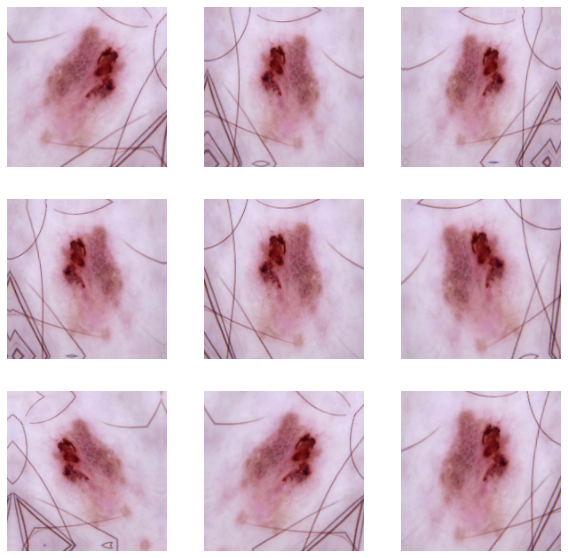

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


### Todo:
### Create the model, compile and train the model


In [18]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model2 = Sequential(
        [
            data_augmentation,
            layers.experimental.preprocessing.Rescaling(1./255, 
            input_shape=(img_height, img_width, 3))
        ])
#first convolutional layer
model2.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
#second convolutional layer
model2.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
#pooling layer
model2.add(MaxPooling2D(pool_size=(2,2)))
#Dropout
model2.add(Dropout(0.2))
#flatten layer
model2.add(Flatten())
#Fully connected layer
model2.add(Dense(128,activation = 'relu'))
#Softmax layer
model2.add(Dense(num_classes, activation = 'softmax' ))

### Compiling the model

In [19]:
## Your code goes here

model2.compile(optimizer='adam',
               loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

### Training the model

In [20]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 192s 1s/step - loss: 3.2814 - accuracy: 0.2585 - val_loss: 1.6469 - val_accuracy: 0.3252
Epoch 2/20
169/169 [==============================] - 191s 1s/step - loss: 1.5825 - accuracy: 0.3891 - val_loss: 1.5658 - val_accuracy: 0.3987
Epoch 3/20
169/169 [==============================] - 191s 1s/step - loss: 1.4858 - accuracy: 0.4190 - val_loss: 1.3988 - val_accuracy: 0.4647
Epoch 4/20
169/169 [==============================] - 191s 1s/step - loss: 1.4055 - accuracy: 0.4622 - val_loss: 1.3405 - val_accuracy: 0.4922
Epoch 5/20
169/169 [==============================] - 192s 1s/step - loss: 1.3504 - accuracy: 0.4885 - val_loss: 1.3055 - val_accuracy: 0.5264
Epoch 6/20
169/169 [==============================] - 191s 1s/step - loss: 1.2846 - accuracy: 0.5200 - val_loss: 1.2323 - val_accuracy: 0.5612
Epoch 7/20
169/169 [==============================] - 191s 1s/step - loss: 1.2504 - accuracy: 0.5332 - val_loss: 1.3584 - val_accuracy: 0.4915

In [21]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 90, 90, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 90, 90, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 518400)           

### Visualizing the results

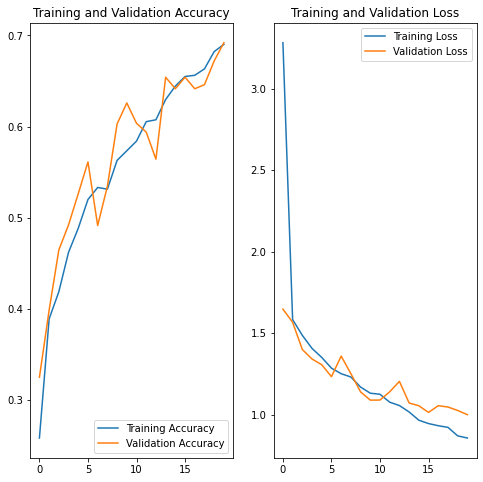

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

<font color='blue'> After augmentation, the overfitting issue is resolved as there is less difference between training and validation set. But the accuracy of the model is much lower. </font>

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
print(data_dir_train)
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

/home/ajaxgen/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train
2239
118


In [24]:
## Your code goes here.

path_to_train = "/home/ajaxgen/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train"

# for class_name in class_names:
#     print(class_name)
#     path_to_class = pathlib.Path(path_to_train + class_name)
#     print(len(list(path_to_class.glob('*/*.jpg'))))

for child in pathlib.Path(path_to_train).iterdir(): 
    print(str(child).split('/')[-1]+':')
    path_to_class = pathlib.Path(child)
    print(len(list(path_to_class.glob('*.jpg'))))

actinic keratosis:
114
pigmented benign keratosis:
462
melanoma:
438
nevus:
357
vascular lesion:
139
seborrheic keratosis:
77
squamous cell carcinoma:
181
basal cell carcinoma:
376
dermatofibroma:
95


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
<font color='blue'>'squamous cell carcinoma' has the least number of samples with 77.</font>
#### - Which classes dominate the data in terms proportionate number of samples?
<font color='blue'><b>'pigmented benign keratosis'</b> has the most number of samples with 463, followed by <b>'melanoma'</b> with 438, <b>'basal cell carcinoma'</b> with 376, and <b>'nevus'</b> with 357.</font>



#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [25]:
# !pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [34]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /home/ajaxgen/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FDF0CFD2


Initialised with 376 image(s) found.
Output directory set to /home/ajaxgen/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDEF4369130>: 100%|█| 500/


Initialised with 95 image(s) found.
Output directory set to /home/ajaxgen/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDED4682D90>: 100%|█| 500/


Initialised with 438 image(s) found.
Output directory set to /home/ajaxgen/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=961x649 at 0x7FDED457A520>: 100%|█| 500/


Initialised with 357 image(s) found.
Output directory set to /home/ajaxgen/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FDED463BC40>: 100%|█| 500/


Initialised with 462 image(s) found.
Output directory set to /home/ajaxgen/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FDF0C044


Initialised with 77 image(s) found.
Output directory set to /home/ajaxgen/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FDED44FDEB0>: 100%|█| 500


Initialised with 181 image(s) found.
Output directory set to /home/ajaxgen/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDFD85C9130>: 100%|█| 500/


Initialised with 139 image(s) found.
Output directory set to /home/ajaxgen/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDF0EC28820>: 100%|█| 500/


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [35]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [40]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))]
path_list

['/home/ajaxgen/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029309.jpg_5733e555-1790-4e88-8a9e-901c5d380a51.jpg',
 '/home/ajaxgen/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029840.jpg_fcc1fbae-8332-412f-80f7-8116e18b53c8.jpg',
 '/home/ajaxgen/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033456.jpg_2a3dd478-9fa0-467f-b738-225c7c6af7f8.jpg',
 '/home/ajaxgen/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030826.jpg_6c34cb61-c55d-4aca-b2c0-4b19300f4dfc.jpg',
 '/home/ajaxgen/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic

In [42]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [44]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [46]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

In [50]:
df2['Label'].value_counts()

actinic keratosis             500
pigmented benign keratosis    500
melanoma                      500
nevus                         500
vascular lesion               500
seborrheic keratosis          500
squamous cell carcinoma       500
basal cell carcinoma          500
dermatofibroma                500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [51]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [52]:
data_dir_train="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training", 
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [54]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [55]:
## your code goes here

model3 = Sequential(
        [
            layers.experimental.preprocessing.Rescaling(1./255, 
            input_shape=(img_height, img_width, 3))
        ])
#first convolutional layer
model3.add(Conv2D(16, kernel_size=(3,3), activation='relu'))
#second convolutional layer
model3.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
#pooling layer
model3.add(MaxPooling2D(pool_size=(2,2)))
#third convolutional layer
model3.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
#pooling layer
model3.add(MaxPooling2D(pool_size=(2,2)))
#Dropout
model3.add(Dropout(0.2))
#flatten layer
model3.add(Flatten())
#Fully connected layer
model3.add(Dense(128,activation = 'relu'))
#Softmax layer
model3.add(Dense(num_classes, activation = 'softmax' ))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [56]:
## your code goes here
model3.compile(optimizer='adam',
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 178, 178, 16)      448       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 176, 176, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 88, 88, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 86, 86, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 43, 43, 64)       

#### **Todo:**  Train your model

In [57]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 113s 665ms/step - loss: 2.0312 - accuracy: 0.2875 - val_loss: 1.5014 - val_accuracy: 0.4595
Epoch 2/50
169/169 [==============================] - 111s 654ms/step - loss: 1.3994 - accuracy: 0.4909 - val_loss: 1.2064 - val_accuracy: 0.5598
Epoch 3/50
169/169 [==============================] - 112s 660ms/step - loss: 1.0436 - accuracy: 0.6241 - val_loss: 1.0850 - val_accuracy: 0.6147
Epoch 4/50
169/169 [==============================] - 112s 662ms/step - loss: 0.8129 - accuracy: 0.7111 - val_loss: 0.9561 - val_accuracy: 0.6711
Epoch 5/50
169/169 [==============================] - 111s 658ms/step - loss: 0.6054 - accuracy: 0.7867 - val_loss: 0.9913 - val_accuracy: 0.6778
Epoch 6/50
169/169 [==============================] - 112s 660ms/step - loss: 0.4985 - accuracy: 0.8322 - val_loss: 1.0230 - val_accuracy: 0.6741
Epoch 7/50
169/169 [==============================] - 111s 657ms/step - loss: 0.3864 - accuracy: 0.8674 - val_loss: 0.9396 -

#### **Todo:**  Visualize the model results

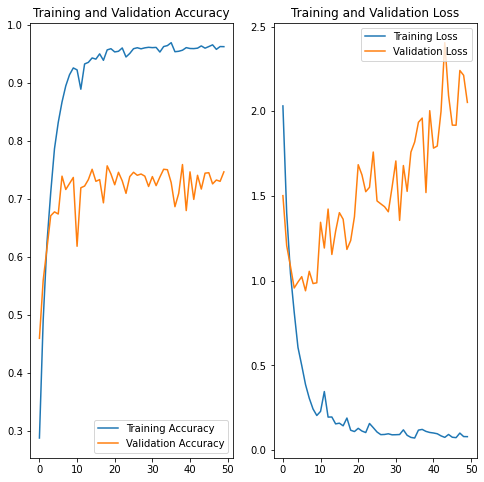

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



<font color='blue'> The model is still showing high level of overfitting. We can try using a simpler model than the previous one as more complex models tend to overfit. Let's try with keeping two convolutional layers, and increase the dropout value 0.6 to control regularization. </font>

In [86]:
model4 = Sequential(
        [
            layers.experimental.preprocessing.Rescaling(1./255, 
            input_shape=(img_height, img_width, 3))
        ])
#first convolutional layer
model4.add(Conv2D(16, kernel_size=(3,3), activation='relu'))
#second convolutional layer
#model4.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
#pooling layer
model4.add(MaxPooling2D(pool_size=(2,2)))
#Dropout
model4.add(Dropout(0.6))
#third convolutional layer
model4.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
#pooling layer
model4.add(MaxPooling2D(pool_size=(2,2)))
#Dropout
model4.add(Dropout(0.6))
#flatten layer
model4.add(Flatten())
#Fully connected layer
model4.add(Dense(64,activation = 'relu'))
#Softmax layer
model4.add(Dense(num_classes, activation = 'softmax' ))

In [87]:
## your code goes here
model4.compile(optimizer='adam',
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

model4.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_9 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 178, 178, 16)      448       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 89, 89, 16)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 89, 89, 16)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 87, 87, 32)        4640      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 43, 43, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 43, 43, 32)      

In [88]:
epochs = 30
history = model4.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 45s 260ms/step - loss: 2.2705 - accuracy: 0.1838 - val_loss: 1.9910 - val_accuracy: 0.2034
Epoch 2/30
169/169 [==============================] - 43s 255ms/step - loss: 1.7737 - accuracy: 0.3411 - val_loss: 1.8822 - val_accuracy: 0.2487
Epoch 3/30
169/169 [==============================] - 42s 248ms/step - loss: 1.6206 - accuracy: 0.3915 - val_loss: 1.6609 - val_accuracy: 0.3697
Epoch 4/30
169/169 [==============================] - 42s 250ms/step - loss: 1.5285 - accuracy: 0.4232 - val_loss: 1.6088 - val_accuracy: 0.3675
Epoch 5/30
169/169 [==============================] - 42s 247ms/step - loss: 1.4529 - accuracy: 0.4509 - val_loss: 1.5398 - val_accuracy: 0.3957
Epoch 6/30
169/169 [==============================] - 42s 246ms/step - loss: 1.3862 - accuracy: 0.4598 - val_loss: 1.4528 - val_accuracy: 0.4209
Epoch 7/30
169/169 [==============================] - 43s 255ms/step - loss: 1.3468 - accuracy: 0.4761 - val_loss: 1.4178 - val_ac

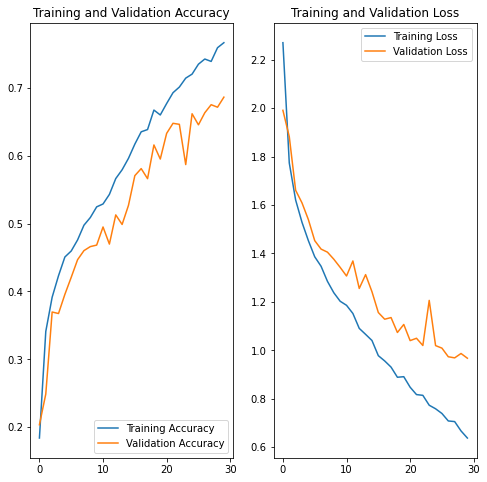

In [89]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<font color='blue'> The difference between the training and validation has reduced significantly but still shows signs of overfitting. Also the accuracy has taken a hit - falling from ~96 precent in the previous model to ~76 in this model. Let's see if a lower dropout will improve the accuracy.</font>

In [101]:
model5 = Sequential(
        [
            layers.experimental.preprocessing.Rescaling(1./255, 
            input_shape=(img_height, img_width, 3))
        ])
#first convolutional layer
model5.add(Conv2D(16, kernel_size=(3,3), activation='relu'))
#second convolutional layer
#model5.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
#pooling layer
model5.add(MaxPooling2D(pool_size=(2,2)))
#Dropout
model5.add(Dropout(0.5))
#third convolutional layer
model5.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
#pooling layer
model5.add(MaxPooling2D(pool_size=(2,2)))
#Dropout
model5.add(Dropout(0.5))
#flatten layer
model5.add(Flatten())
#Fully connected layer
model5.add(Dense(64,activation = 'relu'))
#Softmax layer
model5.add(Dense(num_classes, activation = 'softmax' ))

In [102]:
## your code goes here
model5.compile(optimizer='adam',
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

model5.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_13 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 178, 178, 16)      448       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 89, 89, 16)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 89, 89, 16)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 87, 87, 32)        4640      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 43, 43, 32)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 43, 43, 32)      

In [103]:
epochs = 30
history = model5.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 42s 245ms/step - loss: 2.4350 - accuracy: 0.1300 - val_loss: 2.1699 - val_accuracy: 0.2116
Epoch 2/30
169/169 [==============================] - 42s 245ms/step - loss: 2.0472 - accuracy: 0.2209 - val_loss: 2.0612 - val_accuracy: 0.2494
Epoch 3/30
169/169 [==============================] - 42s 244ms/step - loss: 1.8442 - accuracy: 0.2993 - val_loss: 1.8572 - val_accuracy: 0.3125
Epoch 4/30
169/169 [==============================] - 41s 244ms/step - loss: 1.7096 - accuracy: 0.3288 - val_loss: 1.7480 - val_accuracy: 0.3348
Epoch 5/30
169/169 [==============================] - 42s 246ms/step - loss: 1.5941 - accuracy: 0.3865 - val_loss: 1.7055 - val_accuracy: 0.4016
Epoch 6/30
169/169 [==============================] - 41s 242ms/step - loss: 1.4980 - accuracy: 0.4156 - val_loss: 1.5714 - val_accuracy: 0.4157
Epoch 7/30
169/169 [==============================] - 41s 242ms/step - loss: 1.4327 - accuracy: 0.4407 - val_loss: 1.5222 - val_ac

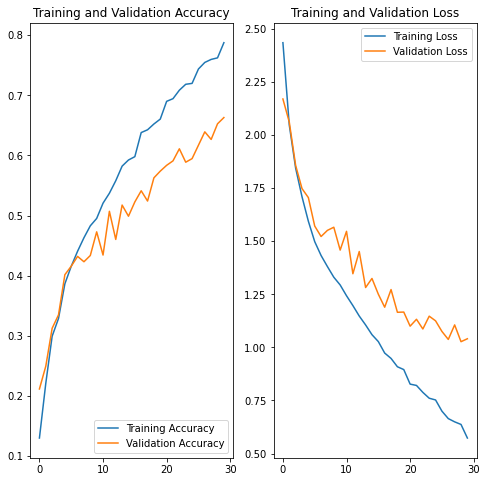

In [104]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<font color='blue'> The accuracy has imroved slightly, but there is still some overfitting. </font>